# 05_Model Comparison — Credit Card Fraud Detection

## Objective
This notebook compares multiple classification models for fraud detection
under the same preprocessing, evaluation metrics, and business-aligned
threshold selection framework.

## Persisting Final Model Artifacts

To enable downstream business evaluation and cost-sensitive analysis,
the trained models and their predicted probabilities are persisted as artifacts.

Saving model outputs ensures that:
- Cost evaluation is fully decoupled from model training
- All models are compared under identical data and assumptions
- Results are reproducible and production-oriented

The persisted artifacts will be reused in the cost evaluation stage
without retraining or re-running the full comparison pipeline.

In [41]:
import numpy as np
import pandas as pd
import joblib

# Metrics
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    confusion_matrix
)

# Reproducibility
np.random.seed(42)

In [42]:
# Load preprocessed train/test splits
X_train = joblib.load("../artifacts/X_train.pkl")
X_test  = joblib.load("../artifacts/X_test.pkl")
y_train = joblib.load("../artifacts/y_train.pkl")
y_test  = joblib.load("../artifacts/y_test.pkl")

# Quick sanity check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 30), (56962, 30), (227845,), (56962,))

## Unified Evaluation Framework

To ensure a fair and unbiased comparison between different models,
a unified evaluation function is used across all experiments.

This guarantees that:
- All models are evaluated using the same probability threshold logic
- Precision and recall are computed consistently
- Confusion matrices are directly comparable

This approach avoids metric leakage and aligns the comparison process
with real-world model selection practices.


In [43]:
def evaluate_model(y_true, y_proba, threshold):
    """
    Evaluate a model at a given probability threshold.
    """
    y_pred = (y_proba >= threshold).astype(int)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    }

## Logistic Regression — Baseline Reference

The previously trained Logistic Regression model is used as a baseline
reference point for comparison.

No retraining is performed in this notebook.
Instead, the stored prediction probabilities are reused to ensure a
fair comparison under identical evaluation conditions.

In [44]:
# Load baseline model outputs
baseline_outputs = joblib.load("../artifacts/model_outputs_baseline.pkl")

y_test_baseline = baseline_outputs["y_test"]
y_proba_baseline = baseline_outputs["y_pred_proba"]

### Baseline Performance — Threshold-Independent Evaluation

Before comparing multiple models, we first establish a reference performance
for the baseline Logistic Regression model.

PR-AUC is used as a threshold-independent metric that measures the model’s
ability to rank fraudulent transactions above normal ones. This metric is
particularly suitable for highly imbalanced fraud detection problems and
serves as the primary comparison criterion across all models.

In [45]:
# PR-AUC for baseline Logistic Regression
baseline_pr_auc = average_precision_score(
    y_test_baseline,
    y_proba_baseline
)

baseline_pr_auc

0.7159122424484009

### Baseline Performance — Operating Threshold Evaluation

While PR-AUC evaluates ranking quality, real-world fraud detection systems
require a concrete decision threshold.

The baseline model is therefore evaluated at the previously selected operating
threshold (0.7) to quantify the trade-off between fraud recall and false alert
volume. This establishes a practical reference point for comparing operational
performance across models.

In [46]:
baseline_threshold = 0.7

baseline_eval = evaluate_model(
    y_test_baseline,
    y_proba_baseline,
    baseline_threshold
)

baseline_eval

{'precision': 0.12141882673942701,
 'recall': 0.9081632653061225,
 'confusion_matrix': array([[56220,   644],
        [    9,    89]])}

## Random Forest Classifier

Random Forest is evaluated as a non-linear, tree-based model to assess whether
capturing feature interactions can improve fraud detection performance over
the linear Logistic Regression baseline.

The model is trained using the same preprocessed data and evaluated using the
same metrics and thresholding framework to ensure a fair comparison.

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# save trained model
joblib.dump(rf_model, "../models/random_forest_final.pkl")

# Predict fraud probabilities on the test set
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# save outputs
joblib.dump(
    {
        "model_name": "random_forest",
        "y_test": y_test,
        "y_pred_proba": rf_proba
    },
    "../artifacts/model_outputs_random_forest.pkl"
)

['../artifacts/model_outputs_random_forest.pkl']

### Random Forest — Threshold-Independent Evaluation (PR-AUC)

In [48]:
rf_pr_auc = average_precision_score(
    y_test,
    rf_proba
)

rf_pr_auc

0.8541999432510914

### Random Forest — Operating Threshold Evaluation

In [49]:
rf_threshold = 0.7

rf_eval = evaluate_model(
    y_test,
    rf_proba,
    rf_threshold
)

rf_eval

{'precision': 0.9705882352941176,
 'recall': 0.673469387755102,
 'confusion_matrix': array([[56862,     2],
        [   32,    66]])}

### Random Forest — Threshold Tuning

To better align Random Forest with fraud detection objectives,
multiple probability thresholds are evaluated to explore the
precision–recall trade-off and identify a more suitable operating point.

In [50]:
rf_thresholds = np.round(np.arange(0.3, 0.81, 0.05), 2)

rf_results = []

for t in rf_thresholds:
    eval_res = evaluate_model(y_test, rf_proba, t)
    
    rf_results.append({
        "threshold": t,
        "precision": eval_res["precision"],
        "recall": eval_res["recall"]
    })

rf_threshold_df = pd.DataFrame(rf_results)
rf_threshold_df


,threshold,precision,recall
0,0.30,0.922222,0.846939
1,0.35,0.940476,0.806122
2,0.40,0.951807,0.806122
3,0.45,0.949367,0.765306
4,0.50,0.960526,0.744898
5,0.55,0.960000,0.734694
6,0.60,0.972603,0.724490
7,0.65,0.971831,0.704082
8,0.70,0.970588,0.673469
9,0.75,0.967742,0.612245


### Random Forest — Threshold Selection

Based on the precision–recall trade-off, a threshold of 0.35 was selected
as the operating point for Random Forest.

This threshold achieves a strong balance between fraud recall and alert
precision, significantly reducing false positives while maintaining
high fraud detection coverage compared to the baseline Logistic Regression.

In [51]:
rf_final_threshold = 0.35

# Evaluate at threshold 0.35
rf_final_eval = evaluate_model(
    y_test,
    rf_proba,
    rf_final_threshold
)

rf_final_eval


{'precision': 0.9404761904761905,
 'recall': 0.8061224489795918,
 'confusion_matrix': array([[56859,     5],
        [   19,    79]])}

## Interim Model Comparison — Logistic Regression vs Random Forest

At this stage, two models have been evaluated under the same preprocessing
and evaluation framework.

The Logistic Regression model prioritizes fraud recall, successfully detecting
most fraudulent transactions but generating a high volume of false positive alerts.

In contrast, the Random Forest model demonstrates substantially stronger
ranking performance (higher PR-AUC) and dramatically reduces false positives,
at the cost of a moderate reduction in fraud recall.

This comparison highlights the inherent trade-off between fraud detection
coverage and customer experience, and serves as a foundation for evaluating
more advanced models.

In [52]:
comparison_so_far = pd.DataFrame([
    {
        "model": "Logistic Regression",
        "pr_auc": 0.716,
        "threshold": 0.70,
        "precision": baseline_eval["precision"],
        "recall": baseline_eval["recall"],
        "false_positives": baseline_eval["confusion_matrix"][0, 1]
    },
    {
        "model": "Random Forest",
        "pr_auc": rf_pr_auc,
        "threshold": 0.35,
        "precision": rf_final_eval["precision"],
        "recall": rf_final_eval["recall"],
        "false_positives": rf_final_eval["confusion_matrix"][0, 1]
    }
])

comparison_so_far

,model,pr_auc,threshold,precision,recall,false_positives
0,Logistic Regression,0.7160,0.70,0.121419,0.908163,644
1,Random Forest,0.8542,0.35,0.940476,0.806122,5


## Interim Conclusion

The Random Forest model substantially outperforms the Logistic Regression
baseline in terms of ranking quality (PR-AUC) and false positive reduction.

However, this improvement comes with a moderate decrease in fraud recall.
As a result, model selection depends on business priorities:
whether maximizing fraud detection coverage or minimizing customer disruption
is the primary objective.

This interim conclusion establishes a clear baseline for evaluating more
advanced models.

## Gradient Boosting Model — XGBoost

Gradient Boosting is evaluated to determine whether a boosted tree-based
approach can achieve a better balance between fraud recall and false
positive reduction compared to both Logistic Regression and Random Forest.

The model is trained and evaluated under the same preprocessing and
evaluation framework to ensure a fair comparison.

In [53]:
from xgboost import XGBClassifier

# Initialize XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train)

# Save trained model
joblib.dump(xgb_model, "../models/xgboost_final.pkl")

# Predict fraud probabilities on the test set
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Save model outputs
joblib.dump(
    {
        "model_name": "xgboost",
        "y_test": y_test,
        "y_pred_proba": xgb_proba
    },
    "../artifacts/model_outputs_xgboost.pkl"
)

['../artifacts/model_outputs_xgboost.pkl']

### XGBoost — Threshold-Independent Evaluation (PR-AUC)

In [54]:
xgb_pr_auc = average_precision_score(y_test, xgb_proba)
xgb_pr_auc

0.8612459138983352

### XGBoost — Threshold Tuning

In [55]:
xgb_thresholds = np.round(np.arange(0.3, 0.81, 0.05), 2)

xgb_results = []

for t in xgb_thresholds:
    eval_res = evaluate_model(y_test, xgb_proba, t)
    xgb_results.append({
        "threshold": t,
        "precision": eval_res["precision"],
        "recall": eval_res["recall"]
    })

xgb_threshold_df = pd.DataFrame(xgb_results)
xgb_threshold_df

,threshold,precision,recall
0,0.30,0.554140,0.887755
1,0.35,0.581081,0.877551
2,0.40,0.623188,0.877551
3,0.45,0.656250,0.857143
4,0.50,0.672000,0.857143
5,0.55,0.682927,0.857143
6,0.60,0.691667,0.846939
7,0.65,0.741071,0.846939
8,0.70,0.754545,0.846939
9,0.75,0.783019,0.846939


### XGBoost — Selected Operating Threshold

Based on the precision–recall trade-off, a threshold of 0.50 was selected
as the operating point for XGBoost to balance fraud detection coverage
and false alert volume.

In [56]:
xgb_final_threshold = 0.50

xgb_final_eval = evaluate_model(
    y_test,
    xgb_proba,
    xgb_final_threshold
)

xgb_final_eval

{'precision': 0.672,
 'recall': 0.8571428571428571,
 'confusion_matrix': array([[56823,    41],
        [   14,    84]])}

## Final Model Comparison

The following table summarizes the performance of all evaluated models
using their selected operating thresholds.

Each model is compared in terms of ranking quality (PR-AUC), fraud recall,
precision, and false positive volume to support an informed final model
selection decision.

In [57]:
final_comparison = pd.DataFrame([
    {
        "model": "Logistic Regression",
        "pr_auc": 0.716,
        "threshold": 0.70,
        "precision": baseline_eval["precision"],
        "recall": baseline_eval["recall"],
        "false_positives": baseline_eval["confusion_matrix"][0, 1]
    },
    {
        "model": "Random Forest",
        "pr_auc": rf_pr_auc,
        "threshold": 0.35,
        "precision": rf_final_eval["precision"],
        "recall": rf_final_eval["recall"],
        "false_positives": rf_final_eval["confusion_matrix"][0, 1]
    },
    {
        "model": "XGBoost",
        "pr_auc": xgb_pr_auc,
        "threshold": 0.50,
        "precision": xgb_final_eval["precision"],
        "recall": xgb_final_eval["recall"],
        "false_positives": xgb_final_eval["confusion_matrix"][0, 1]
    }
])

final_comparison

,model,pr_auc,threshold,precision,recall,false_positives
0,Logistic Regression,0.716000,0.70,0.121419,0.908163,644
1,Random Forest,0.854200,0.35,0.940476,0.806122,5
2,XGBoost,0.861246,0.50,0.672000,0.857143,41


## Final Model Selection

Three models were evaluated under a unified preprocessing and evaluation
framework: Logistic Regression, Random Forest, and XGBoost.

Logistic Regression achieved the highest fraud recall but generated an
excessive number of false positive alerts, making it impractical for
real-world deployment.

Random Forest significantly reduced false positives but missed a larger
portion of fraudulent transactions.

XGBoost achieved the best overall balance, delivering the highest ranking
performance (PR-AUC), strong fraud recall, and a substantial reduction in
false positives compared to the baseline.

Based on this trade-off, XGBoost was selected as the preferred production
candidate under a moderate risk tolerance setting.

## Precision–Recall Curve Comparison

The following plot compares the precision–recall trade-offs across all
evaluated models and visually supports the final model selection decision.

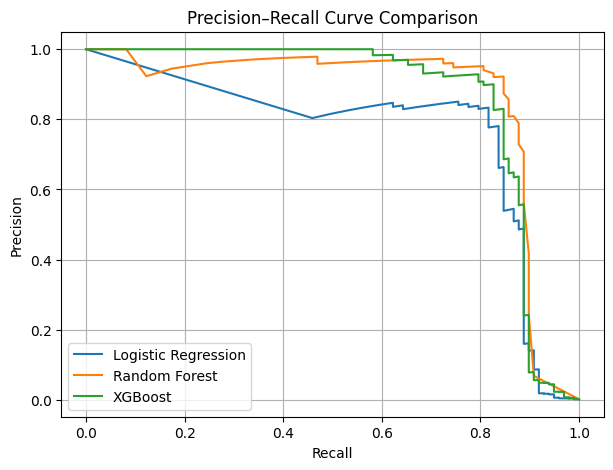

In [58]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": y_proba_baseline,
    "Random Forest": rf_proba,
    "XGBoost": xgb_proba
}

plt.figure(figsize=(7,5))

for name, proba in models.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Final Remarks

This project demonstrates an end-to-end fraud detection pipeline,
from baseline modeling to advanced model comparison and business-aware
model selection.

Through systematic evaluation and threshold tuning, XGBoost was selected
as the final model due to its superior balance between fraud detection
coverage and false positive reduction.

The presented approach reflects real-world decision-making practices
in cost-sensitive and highly imbalanced classification problems.